In [ ]:
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader,ConcatDataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision.models as models

In [ ]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


In [ ]:
if not os.path.exists('./SVHN'):
  import gdown
  url = 'https://drive.google.com/uc?id=10N__ctmFgHKijCla8f-FvPxDCrUImKft'
  gdown.download(url, './SVHN.zip', quiet=False)
  !unzip ./SVHN.zip > /dev/null

Downloading...
From: https://drive.google.com/uc?id=10N__ctmFgHKijCla8f-FvPxDCrUImKft
To: /content/SVHN.zip
701MB [00:07, 88.1MB/s]


use other built-in datasets such as CIFAR10 and/or crop parts from the full size
training images where there is no digits.


The SVHN dataset assigns the label `10` to the digit `0`. However, in this Dataset,we assign the label `0` to the digit `0` to be compatible with PyTorch loss functions which expect the class labels to be in the range `[0, C-1]`

Assign the label 10 to the CIFAR10 dataset

Both dataset size are 32x32，we don't need to resize the pic

In [ ]:
train_transform = transforms.Compose([transforms.ToTensor(),
                                      ])
test_transform = transforms.Compose([transforms.ToTensor(),
                                     ])

batch_size = 64
trainset1 = datasets.SVHN('./data', split='train', download=True, transform=train_transform)
trainset2 = datasets.CIFAR10('./data', train=True, download=True, transform=train_transform)
trainset2.targets = np.asarray(trainset2.targets)
trainset2.targets[:] = 10
trainset = ConcatDataset([trainset1, trainset2])
testset1 = datasets.SVHN('./data', split='test', download=True, transform=train_transform)
testset2 = datasets.CIFAR10('./data', train=False, download=True, transform=train_transform)
testset2.targets = np.asarray(testset2.targets)
testset2.targets[:] = 10
testset = ConcatDataset([testset1, testset2])
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)


Extracting ./data/cifar-10-python.tar.gz to ./data



Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


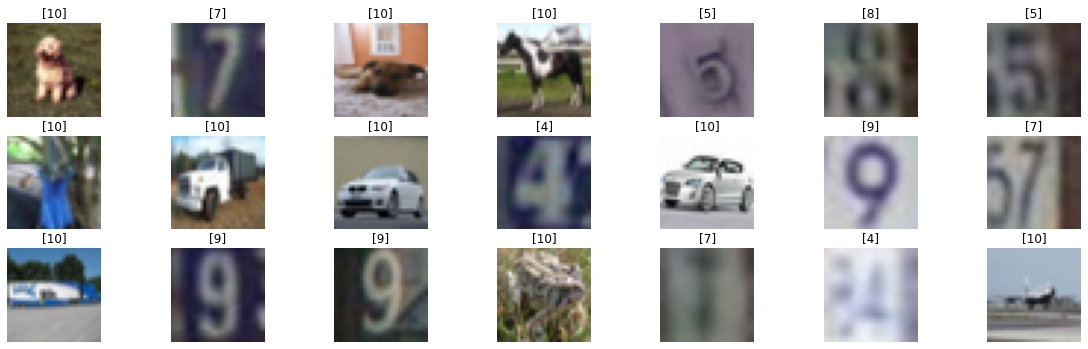

In [ ]:
images, labels = next(iter(train_loader))
plt.figure(figsize=(20,10))

for i in range(21):
    plt.subplot(5,7,i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
    plt.title([labels[i].item()])
    plt.axis('off')


Input size is N, Filter size(kernel size) is F, padding size is P,stride is S. Output size is (N-F+2*P)/S +1 

In [ ]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        #...
        self.convolutional = nn.Sequential(
                nn.Conv2d(3,64,5),   #8*28*28
                nn.BatchNorm2d(64),
                nn.ReLU(),
                nn.Dropout(),
                nn.MaxPool2d(2), #8*14*14

                nn.Conv2d(64,256,5),   #16*10*10
                nn.BatchNorm2d(256),
                nn.ReLU(),
                nn.Dropout(),
                nn.MaxPool2d(2), #16*5*5
                
                nn.Conv2d(256,512,5),   #400*1*1
                #nn.BatchNorm2d(400),
                nn.Dropout(),
                nn.ReLU(),

                nn.Conv2d(512,512,1),   #400*1*1
                #nn.BatchNorm2d(400),
                nn.ReLU(),

                nn.Conv2d(512,11,1),   #11*1*1
                nn.ReLU(),

                )

    def forward(self, x):
        #...
        x = self.convolutional(x)
        #reshape x so it becomes flat, except for the first dimension (which is the minibatch)
        return x

In [ ]:
model = Network()
model.to(device)

Network(
  (convolutional): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 256, kernel_size=(5, 5), stride=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Dropout(p=0.5, inplace=False)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(256, 512, kernel_size=(5, 5), stride=(1, 1))
    (11): Dropout(p=0.5, inplace=False)
    (12): ReLU()
    (13): Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1))
    (14): ReLU()
    (15): Conv2d(512, 11, kernel_size=(1, 1), stride=(1, 1))
    (16): ReLU()
  )
)

In [ ]:
def train(model, optimizer, num_epochs=10):
    def loss_fun(output, target):
        return F.cross_entropy(output, target) # logsoftmax and nll included
    out_dict = {'train_acc': [],
              'test_acc': [],
              'train_loss': [],
              'test_loss': []}
  
    for epoch in tqdm(range(num_epochs), unit='epoch'):
        model.train()
        #For each epoch
        train_correct = 0
        train_loss = []
        for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
            data, target = data.to(device), target.to(device)
            #Zero the gradients computed for each weight
            optimizer.zero_grad()
            #Forward pass your image through the network
            output = model(data)
            output = torch.squeeze(output)
            #Compute the loss
            loss = loss_fun(output, target)
            #Backward pass through the network
            loss.backward()
            #Update the weights
            optimizer.step()

            train_loss.append(loss.item())
            #Compute how many were correctly classified
            predicted = output.argmax(1)
            train_correct += (target==predicted).sum().cpu().item()
        #Compute the test accuracy
        test_loss = []
        test_correct = 0
        model.eval()
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            with torch.no_grad():
                output = model(data)
                output = torch.squeeze(output)
            test_loss.append(loss_fun(output, target).cpu().item())
            predicted = output.argmax(1)
            test_correct += (target==predicted).sum().cpu().item()
        out_dict['train_acc'].append(train_correct/len(trainset))
        out_dict['test_acc'].append(test_correct/len(testset))
        out_dict['train_loss'].append(np.mean(train_loss))
        out_dict['test_loss'].append(np.mean(test_loss))
        print(f"Loss train: {np.mean(train_loss):.3f}\t test: {np.mean(test_loss):.3f}\t",
              f"Accuracy train: {out_dict['train_acc'][-1]*100:.1f}%\t test: {out_dict['test_acc'][-1]*100:.1f}%")
    return out_dict

In [ ]:
optimizer_SGD = torch.optim.SGD(model.parameters(), lr=0.001)
out_dict_SGD = train(model, optimizer_SGD)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Loss train: 1.499	 test: 1.760	 Accuracy train: 50.2%	 test: 46.0%



Loss train: 1.193	 test: 1.487	 Accuracy train: 61.2%	 test: 59.1%



Loss train: 0.885	 test: 1.228	 Accuracy train: 72.4%	 test: 69.6%



Loss train: 0.680	 test: 0.995	 Accuracy train: 79.2%	 test: 79.4%



Loss train: 0.566	 test: 0.866	 Accuracy train: 83.1%	 test: 82.8%



Loss train: 0.492	 test: 0.796	 Accuracy train: 85.6%	 test: 83.3%



Loss train: 0.444	 test: 0.708	 Accuracy train: 86.9%	 test: 86.4%



Loss train: 0.411	 test: 0.742	 Accuracy train: 87.9%	 test: 85.7%



Loss train: 0.388	 test: 0.678	 Accuracy train: 88.6%	 test: 86.9%



Loss train: 0.369	 test: 0.821	 Accuracy train: 89.1%	 test: 77.1%



In [ ]:
optimizer_Adam = torch.optim.Adam(model.parameters())
out_adam = train(model, optimizer_Adam)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Loss train: 0.573	 test: 0.845	 Accuracy train: 83.2%	 test: 77.8%



Loss train: 0.370	 test: 0.643	 Accuracy train: 89.2%	 test: 85.7%



Loss train: 0.320	 test: 0.571	 Accuracy train: 90.7%	 test: 88.6%



Loss train: 0.294	 test: 0.421	 Accuracy train: 91.5%	 test: 90.2%



Loss train: 0.272	 test: 0.417	 Accuracy train: 92.1%	 test: 91.2%



Loss train: 0.252	 test: 0.386	 Accuracy train: 92.7%	 test: 92.5%



Loss train: 0.238	 test: 0.357	 Accuracy train: 93.2%	 test: 92.3%



Loss train: 0.229	 test: 0.340	 Accuracy train: 93.5%	 test: 92.0%



Loss train: 0.219	 test: 0.345	 Accuracy train: 93.7%	 test: 92.1%



Loss train: 0.205	 test: 0.441	 Accuracy train: 94.1%	 test: 89.6%



In [ ]:
# plt.plot(out_dict_SGD_DA['train_acc'])
# plt.plot(out_dict_SGD_DA['test_acc'])
# plt.plot(out_dict_Adam_DA['train_acc'])
# plt.plot(out_dict_Adam_DA['test_acc'])
# plt.legend(('SGD Train acc','SGD Test acc','Adam Train acc','Adam Test acc'))
# plt.xlabel('Epoch number')
# plt.ylabel('Accuracy')
# plt.title('Train with Data Augmentation')
# plt.show()

In [ ]:
def calculate_dims(img):
    
    def conv(h_in, w_in, K, S=1):
        h_out = math.floor((h_in - K)/S + 1)
        w_out = math.floor((w_in - K)/S + 1)
        return (h_out, w_out)
    
    def maxpool(h_in, w_in, K=2, S=2):
        h_out = math.floor((h_in - K)/S + 1)
        w_out = math.floor((w_in - K)/S + 1)
        return (h_out, w_out)

    h, w, c = img.shape
    init_dims = (h, w)
    dims1 = conv(*init_dims, K=5)
    dims2 = maxpool(*dims1)
    dims3 = conv(*dims2, K=5)
    dims4 = maxpool(*dims3)
    dims5 = conv(*dims4, K=5)
    dims6 = conv(*dims5, K=1)
    final_dims = conv(*dims6, K=1)

    return final_dims

In [ ]:
# def show_bbox(img, output): 

#     # Box values
#     box_values = output[0].argmax(0).cpu().numpy()
#     prob = F.softmax(output, dim=1)[0].data.cpu().numpy()
    
#     # Number of boxes horisontally and vertically
#     horisontal_boxes = output.size()[3]
#     vertical_boxes = output.size()[2]

#     # Stride size - how many pixels are skipped each time we move the box
#     horisontal_strides = (img.shape[1] - 32) / (horisontal_boxes - 1)
#     vertical_strides = (img.shape[0] - 32) / (vertical_boxes - 1)  

#     # Create figure and axes
#     fig, ax = plt.subplots(1)

#     # Display the image
#     ax.imshow(img)

#     # First maximum bbox
#     for c in range(0, 10):
#         coord = np.where(prob[c] == np.amax(prob[c]))
#         v_coord = coord[0][0]
#         h_coord = coord[1][0]
#         prob_val = prob[c][v_coord][h_coord]
#         if (prob_val >= 0.6 and c in box_values): # box_values condition
#             print(f'{c}, prob={prob_val:.2f}, x={h_coord}, y={v_coord}')
#             box1 = (h_coord*horisontal_strides, v_coord*vertical_strides, 32, 32)
#             rect = patches.Rectangle((h_coord * horisontal_strides,
#                                       v_coord * vertical_strides),
#                                      32,
#                                      32,
#                                      linewidth=1,
#                                      edgecolor='C'+str(c),
#                                      facecolor='none')
#             # Add the patch to the Axes
#             ax.add_patch(rect)
#             ax.annotate(str(c), (h_coord * horisontal_strides,
#                                  v_coord * vertical_strides))

In [ ]:
def show_bbox(img, output): 

    # Box values
    box_values = output[0].argmax(0).cpu().numpy()
    prob = F.softmax(output, dim=1)[0].data.cpu().numpy()
    
    # # Number of boxes horisontally and vertically
    # horisontal_boxes = output.size()[3]
    # vertical_boxes = output.size()[2]

    # # Stride size - how many pixels are skipped each time we move the box
    # horisontal_strides = (img.shape[1] - 32) / (horisontal_boxes - 1)
    # vertical_strides = (img.shape[0] - 32) / (vertical_boxes - 1)  

    # Create figure and axes
    fig, ax = plt.subplots(1)

    # Display the image
    ax.imshow(img)

    # First maximum bbox
    for c in range(0, 10):
        coord = np.where(prob[c] == np.amax(prob[c]))
        v_coord = coord[0][0]
        h_coord = coord[1][0]
        prob_val = prob[c][v_coord][h_coord]
        x1 = 4 * v_coord
        y1 = 4 * h_coord
        if (prob_val >= 0.6 and c in box_values): # box_values condition
            print(f'{c}, prob={prob_val:.2f}, x={h_coord}, y={v_coord}')
            #box1 = (h_coord*horisontal_strides, v_coord*vertical_strides, 32, 32)
            rect = patches.Rectangle((y1,
                                      x1),
                                     32,
                                     32,
                                     linewidth=1,
                                     edgecolor='C'+str(c),
                                     facecolor='none')
            # Add the patch to the Axes
            ax.add_patch(rect)
            ax.annotate(str(c), (y1,
                                 x1))

In [ ]:
# def show_bbox(img, output): 

#     # Box values
#     box_values = output[0].argmax(0).cpu().numpy()         # argmax(0) : return the position of the max value in every row 
#     prob = F.softmax(output, dim=1)[0].data.cpu().numpy()  # dim = 1: row.  Compute the value of the first row in output which are sumed to 1.0  
    
#     # Number of boxes horisontally and vertically
#     horisontal_boxes = output.size()[3]   # c*h*w
#     vertical_boxes = output.size()[2] 

#     # Stride size - how many pixels are skipped each time we move the box
#     horisontal_strides = (img.shape[1] - 32) / (horisontal_boxes - 1)
#     vertical_strides = (img.shape[0] - 32) / (vertical_boxes - 1)  

#     # Create figure and axes
#     fig, ax = plt.subplots(1)

#     # Display the image
#     ax.imshow(img)

#     # First maximum bbox
#     for c in range(0, 10):
#         coord = np.where(prob[c] == np.amax(prob[c]))    #np.where(condition): output the position of which meets the condition. np.amax(): get the max value  
#         v_coord = coord[0][0]
#         h_coord = coord[1][0]
#         %print(coord)
#         prob_val = prob[c][v_coord][h_coord]
#         if (prob_val >= 0.6 and c in box_values): # box_values condition
#             print(f'{c}, prob={prob_val:.2f}, x={h_coord}, y={v_coord}')
#             box1 = (h_coord*horisontal_strides, v_coord*vertical_strides, 32, 32)
#             rect = patches.Rectangle((h_coord * horisontal_strides,              # patches.Rectangle((x,y), width, height)  矩形左下角坐标（x,y)
#                                       v_coord * vertical_strides),
#                                      32,
#                                      32,
#                                      linewidth=1,
#                                      edgecolor='C'+str(c),
#                                      facecolor='none')
#             # Add the patch to the Axes
#             ax.add_patch(rect)
#             ax.annotate(str(c), (h_coord * horisontal_strides,                   # 注释内容和注释位置
#                                  v_coord * vertical_strides))

In [ ]:
import cv2
import math
import matplotlib.patches as patches
num = 444
img = cv2.imread(f'SVHN/test/{num}.png')
img_trans = torch.FloatTensor(img).permute(2,0,1).to(device)
output = model(img_trans.unsqueeze(0)).detach() 
#data_test[f'{num}.png']['boxes']

In [ ]:
img.shape

(47, 123, 3)

In [ ]:
output.shape

torch.Size([1, 11, 4, 23])

In [ ]:
print(output[0].argmax(0))

tensor([[10, 10, 10, 10, 10, 10, 10, 10, 10,  2, 10, 10, 10, 10, 10, 10, 10, 10,
         10,  6,  1, 10, 10],
        [10, 10, 10, 10, 10, 10, 10,  5,  5,  2,  2,  3,  3, 10, 10, 10, 10, 10,
         10,  6,  1, 10, 10],
        [10, 10, 10, 10, 10, 10, 10,  5,  5,  2,  2,  5,  3, 10, 10, 10, 10, 10,
         10,  4,  1, 10, 10],
        [10, 10, 10, 10, 10, 10, 10,  5,  5,  5,  6, 10, 10, 10, 10, 10, 10, 10,
         10,  6,  1, 10, 10]], device='cuda:0')


In [ ]:
calculate_dims(img)

(4, 23)

In [ ]:
output[0].argmax(0).cpu().numpy()

array([[10, 10, 10, 10, 10, 10, 10, 10, 10,  2, 10, 10, 10, 10, 10, 10,
        10, 10, 10,  6,  1, 10, 10],
       [10, 10, 10, 10, 10, 10, 10,  5,  5,  2,  2,  3,  3, 10, 10, 10,
        10, 10, 10,  6,  1, 10, 10],
       [10, 10, 10, 10, 10, 10, 10,  5,  5,  2,  2,  5,  3, 10, 10, 10,
        10, 10, 10,  4,  1, 10, 10],
       [10, 10, 10, 10, 10, 10, 10,  5,  5,  5,  6, 10, 10, 10, 10, 10,
        10, 10, 10,  6,  1, 10, 10]])

0, prob=1.00, x=31, y=17
1, prob=1.00, x=11, y=0
2, prob=1.00, x=20, y=6
3, prob=1.00, x=63, y=7
4, prob=1.00, x=7, y=0
5, prob=1.00, x=59, y=0
6, prob=1.00, x=0, y=0
7, prob=1.00, x=82, y=2
8, prob=1.00, x=63, y=15
9, prob=1.00, x=81, y=2


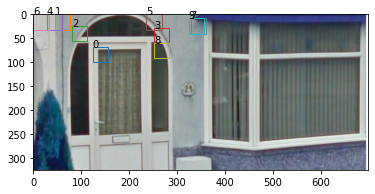

In [ ]:
show_bbox(img, output)